**D3APL: Aplicações em Ciência de Dados** <br/>
IFSP Campinas

Prof. Dr. Samuel Martins (Samuka) <br/><br/>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Animal Dataset - v1
We will evaluate some **multiclass classification** CNNs to predict the classes of the **Animal Dataset**: https://www.kaggle.com/datasets/alessiocorrado99/animals10


Target goals:
- Proposed CNN's Architecture
- Dataset Preprocessing
    + Import the image data
    + Preprocessing the data
        - Image rescaling
        - Normalization
    + Save the preprocessed data
    + Convert the images into a _feature matrix (X)_ and a list of _target labels (y)_
- Train CNN
    - Use early stopping regularization
- Evaluate a simple CNN architecture

## 1. Set up

#### 1.1 TensorFlow

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.0'

**GPU available?**

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1.2 Fixing the seed for reproducibility (optional)
That's a try for reprodubility in Keras. See more on:
- https://stackoverflow.com/a/59076062
- https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

In [4]:
import os
import tensorflow as tf
import numpy as np
import random

def reset_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    
# make some random data
reset_random_seeds()

### 1.3. Dataset
**Animal Dataset**: https://www.kaggle.com/datasets/alessiocorrado99/animals10

#### 1.3.1 Load the dataset
**Balanced dataset**: _'../datasets/animal-dataset/animals_dataset_balanced.csv'_

In [5]:
import pandas as pd

In [6]:
dataset_df = pd.read_csv('../datasets/animals-dataset/animals_dataset_balanced.csv')

In [7]:
dataset_df

,image_pathname,class
0,../datasets/animals-dataset/raw-img/cane/OIP-u...,dog
1,../datasets/animals-dataset/raw-img/cane/OIP-V...,dog
2,../datasets/animals-dataset/raw-img/cane/OIP-0...,dog
3,../datasets/animals-dataset/raw-img/cane/OIP-b...,dog
4,../datasets/animals-dataset/raw-img/cane/OIP-8...,dog
...,...,...
13995,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel
13996,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel
13997,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel
13998,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel


#### 1.3.2 Dataset Info

In [9]:
class_names = sorted(dataset_df["class"].unique())
n_classes = len(class_names)

print(f'Number of classes: {n_classes}')
print(f'Classes: {class_names}')

Number of classes: 10
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [ ]:
# number of samples per class
dataset_df['class'].value_counts()

## 2. Building and Training a CNN via Keras

### 2.1 Defining the Network Architecture
That's a simple CNN for _Multiclass Classification_:
- **INPUT [64x64x3]**
- CONV [32, 4x4x3, 'valid']
- RELU
- MAX_POOL [2x2, stride=(1,1)]
- CONV [32, 4x4x3, 'valid']
- RELU
- MAX_POOL [2x2, stride=(1,1)]
- FLATTEN
- FC [256]
- RELU
- FC [10, 'softmax']  # number of classes

- optimizer: SGD with `learning_rate=0.01`
- kernel_initializer: "glorot_uniform"
- bias_initializer: "zeros"
- **Early stopping**

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

def build_cnn(input_shape, n_classes):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(4,4), input_shape=input_shape, activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), activation='relu'),
        MaxPool2D(pool_size=(2,2)),

        Flatten(),

        Dense(256, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    
    return model

In [11]:
input_shape = (64, 64, 3)

model = build_cnn(input_shape, n_classes)

opt = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 256)               1

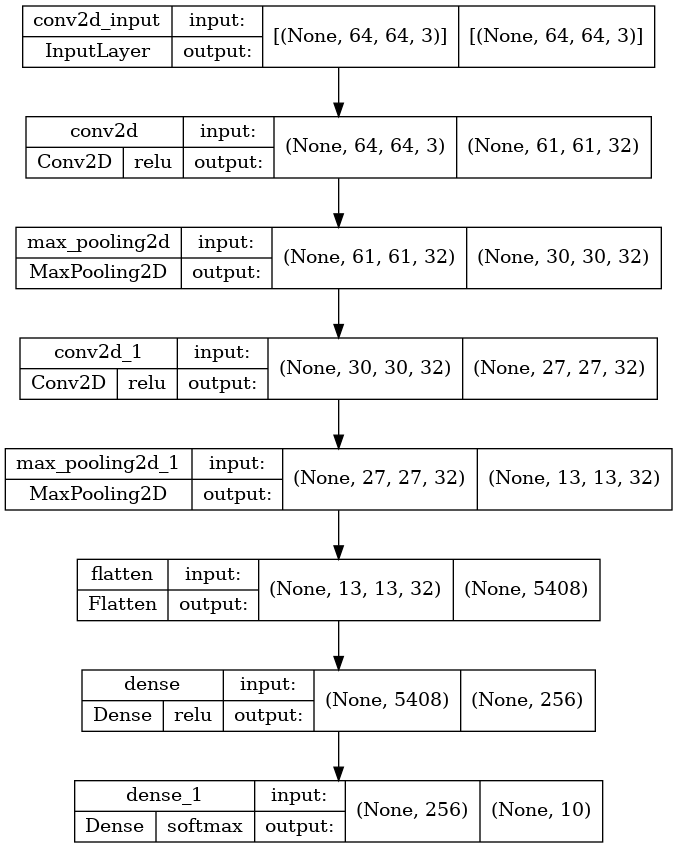

In [13]:
from tensorflow.keras.utils import plot_model
# vertical
plot_model(model, show_shapes=True, show_layer_activations=True)

### 2.2 Image Preprocessing

- **Image Resizing**
    + Since the **input layer's shape** and the **images' shape** ***are different***, we need to **resize** the images to the **input layer's shape**.
    + Let's use the function `c2.resize()` for that: https://learnopencv.com/image-resizing-with-opencv/#resize-by-wdith-height
- **Intensity (feature) Scaling**
    + Animals dataset contain 24-bit color images, i.e., it is a color image where each channel is a 8-bit grayscale image (values from 0 to 255)
    + We will simply rescale the values to [0, 1] by dividing them by 255.
- **Label Encoder**
    + Encode the string classes into class integers from 0 to n_classes-1
    + https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
    
Create a function that performs all these steps.

In [ ]:
X, y, label_encoder = preprocess_animals_dataset(dataset_df, new_dims=(64, 64))

In [ ]:
print(f'Feature matrix X: {X.shape}')
print(f'Target labels (classes) y: {y.shape}')

In [ ]:
# rescaled 24-bit color image
print(f'Min. value of X: {X.min()}')
print(f'Max. value of X: {X.max()}\n')

Since this function may be useful in other notebooks, let's create a **python file/module** to make it available:

**File:** `animals_utils.py`

In [ ]:
print(f'Feature matrix X: {X.shape}')
print(f'Target labels (classes) y: {y.shape}')

In [ ]:
# rescaled 24-bit color image
print(f'Min. value of X: {X.min()}')
print(f'Max. value of X: {X.max()}\n')

In [ ]:
label_encoder.classes_

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X[0])

#### **Observation**

While _image resizing_ and _feature scaling_ **don't learn** any parameter, our _label encoding_ learns the convertion between _class names_ to _sequential integers_ considering the **entire data**. <br/>
To consider a _real scenario_, we shouldn't do that. We should _split the data_ into _training and testing sets_ ***before* applying any preprocessing** to avoid _snooping bias_. <br/>

Also, the most indicated way is to create a **Scikit-learn `Pipeline`** to _preprocess our data_. For that, we would have to create a _custom sklearn transformer_ to resize the images as well as for the simple feature normalization, and label encoding. Then, we could use this **preprocessing step** in production to preprocess any data!

### 2.3 Split the data

Our dataframe `dataset_df` corresponds to the full formated as a "table" with _image pathnames_ and _image classes_ <br/>
`X` is our _feature matrix_ which corresponds to the resized normalized images. <br/>
`y` is the vector with the true labels (classes) of `X`.

Note that each sample `[i]` from `dataset_df` has its corresponding features in `X[i]` and class in `y[i]`. <br/>
To save the pathanme from the original image after spliting the dataset, we will split `dataset_df`. <br/>
Then, we can recovery the indices from the splitted sets to get our _training_ and _testing numpy arrays_.

If the original image pathanmes are not important for you, simply apply `train_test_split` directly over `X` and `y` and be happy =D

In [ ]:
# get the training samples' indices


In [ ]:
# get the testing samples' indices


In [ ]:
# get the training and test numpy arrays from the dataframes' indices


In [ ]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}\n')

print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

### 2.4 Save the Training and Testing Sets (included the preprocessed data)

In [ ]:
import os

out_dir = '../datasets/animals-dataset/preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
dataset_df_train.to_csv(os.path.join(out_dir, 'train.csv'), index=False)
np.save(os.path.join(out_dir, 'train_data_64x64x3.npy'), X_train)
np.save(os.path.join(out_dir, 'train_labels.npy'), y_train)

dataset_df_test.to_csv(os.path.join(out_dir, 'test.csv'), index=False)
np.save(os.path.join(out_dir, 'test_data_64x64x3.npy'), X_test)
np.save(os.path.join(out_dir, 'test_labels.npy'), y_test)

### 2.5 Training with Early Stopping

In case of GPU drivers, we can monitor its use by [_gpustat_](https://github.com/wookayin/gpustat).

On terminal, use: `gpustat -cpi`


#### **Visualizing the training history**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

In [ ]:
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xticks(range(30))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xticks(range(30))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 3. Evaluating and Predicting New Samples by using our Overfitted Model

#### **Evaluation**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#evaluate

In [ ]:
model.evaluate(X_test, y_test)

#### **Prediction**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict

In [ ]:
y_test_proba = model.predict(X_test)
y_test_proba

#### **Class Prediction**
https://stackoverflow.com/a/69503180/7069696

In [ ]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

In [ ]:
from sklearn.metrics import classification_report

class_names = label_encoder.classes_

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

We got a **poor accuracy** of XXXX.

#### **Visualizing misclassification proportion - inverse of recall**

In [ ]:
y_test_class_name = label_encoder.inverse_transform(y_test)
y_test_pred_class_name = label_encoder.inverse_transform(y_test_pred)

In [ ]:
misclassification_mask = y_test_class_name != y_test_pred_class_name

In [ ]:
y_test_error = y_test_class_name[misclassification_mask]
y_test_error

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x=y_test_class_name)

#### **Visualizing some misclassified image**

**Sheep**

In [ ]:
sheep_error_mask = misclassification_mask & (y_test_class_name == "sheep")

np.argwhere(sheep_error_mask)[:3]

In [ ]:
img_idx = 70

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

In [ ]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
img_idx = 94

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

In [ ]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

**Dog**

In [ ]:
dog_error_mask = misclassification_mask & (y_test_class_name == "dog")

np.argwhere(dog_error_mask)[:3]

In [ ]:
img_idx = 10

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

In [ ]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
img_idx = 16

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

In [ ]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Exercise

Repeat the experiments considering different:
-  values for _learning_rate_ of SGD
- optimizers (e.g., 'nadam')
- kernel regularizer (e.g., 'l2')